In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import utils as utils
import torchvision
from torch.cuda.amp import autocast, GradScaler
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import warnings
from torchvision import transforms
from PIL import Image

# Ignore a specific warning
warnings.filterwarnings("ignore")

2023-12-11 16:59:01.145981: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 16:59:01.710566: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/lukas/miniconda3/envs/practical_work/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lukas/miniconda3/envs/practical_work/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed be

In [2]:
# set some seeds
seed = 1908
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Facial Expression Recognition Challenge

## Overview
This notebook takes part in the Facial Expression Recognition Challenge introduced in 2013. The challenge focuses on a facial expression classification dataset gathered from the internet. The challenge ended on Friday, May 31, 2013, with the best achieved accuracy on the public leaderboard of 0.69768 and of 0.71161 on the private leaderboard. The aim of this notebook is to achieve better results, using more advanced ML techniques.

## Challenge Details
### Dataset
The dataset for this challenge comprises facial expressions in 35887 48 x 48 greyscale images, where 28709 of these samples belong to the training set, 3589 to the public test set and 3589 to the private test set. All datasets are very unbalanced, making solutions to the inbalance problems one of the key challanges to achieve a high accuracy score.

### Evaluation
Submissions are scored based on the accuracy of predicting the appropriate emotion class for each image. During the contest, a public leaderboard was maintained and to prevent manual labeling of test data, the final test inputs were only be provided 72 hours before the contest closed to get the final score on the private test set.

## Citation
This challenge is part of the ICML 2013 Workshop on Challenges in Representation Learning. More details about the competition and its results can be found in the following publication:

**Title:** Challenges in Representation Learning: A report on three machine learning contests

**Authors:** Ian Goodfellow, Dumitru Erhan, Pierre-Luc Carrier, Aaron Courville, Mehdi Mirza, Ben Hamner, Will Cukierski, Yichuan Tang, David Thaler, Dong-Hyun Lee, Yingbo Zhou, Chetan Ramaiah, Fangxiang Feng, Ruifan Li, Xiaojie Wang, Dimitris Athanasakis, John Shawe-Taylor, Maxim Milakov, John Park, Radu Ionescu, Marius Popescu, Cristian Grozea, James Bergstra, Jingjing Xie, Lukasz Romaszko, Bing Xu, Zhang Chuang, Yoshua Bengio

**Year:** 2013

**URL:** [Challenges in Representation Learning: A report on three machine learning contests](http://arxiv.org/abs/1307.0414)

This publication provides insights into the challenges, datasets, and results of the ICML 2013 Workshop on Challenges in Representation Learning.

*For more information about the workshop and competition, visit [ICML 2013 Workshop Competition](http://deeplearning.net/icml2013-workshop-competition).*


# Code

## Set up data paths

In [3]:
working_dir = os.getcwd()
dataset_path = "fer2013/fer2013/fer2013.csv"
data_path = os.path.join(working_dir, dataset_path)

In [4]:
df = pd.read_csv(data_path)

## First look at the data and samples

In [5]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
print(f"Total number of samples: {len(df)}")

Total number of samples: 35887


In [7]:
sample_0 = df.iloc[0]

In [8]:
print(sample_0)
print(f"Number of pixels for one sample: {len(sample_0['pixels'].split(' '))}")

emotion                                                    0
pixels     70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
Usage                                               Training
Name: 0, dtype: object
Number of pixels for one sample: 2304


In [9]:
print(f"Shape of one image: {int(2304**(0.5))}")

Shape of one image: 48


In [10]:
print(f"Distinct emotion classes: {sorted(df['emotion'].unique())}")
print(f"Distinct Usage (Set) classes: {df['Usage'].unique()}")

Distinct emotion classes: [0, 1, 2, 3, 4, 5, 6]
Distinct Usage (Set) classes: ['Training' 'PublicTest' 'PrivateTest']


In [11]:
df.emotion

0        0
1        0
2        2
3        4
4        6
        ..
35882    6
35883    3
35884    0
35885    3
35886    2
Name: emotion, Length: 35887, dtype: int64

In [12]:
emotions_dict = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

## Plot the occurence of the different labels in the whole dataset

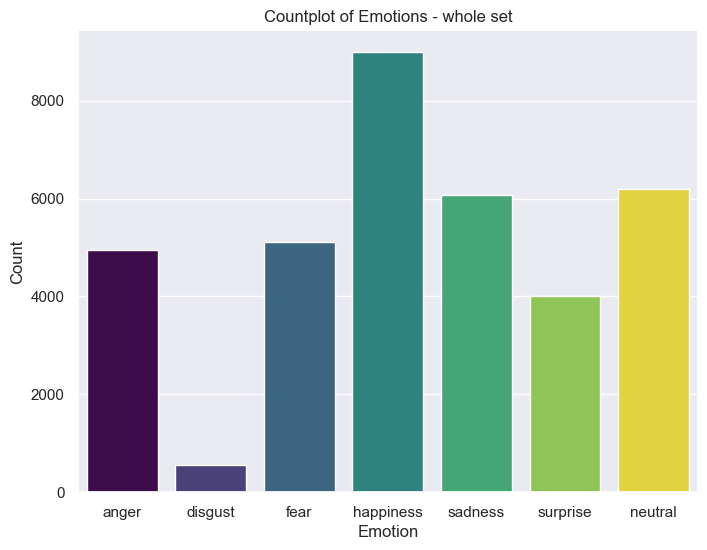

In [13]:
utils.plot_emotion_count(df, emotions_dict, "whole set")

## Plot the images with the corresponding labels

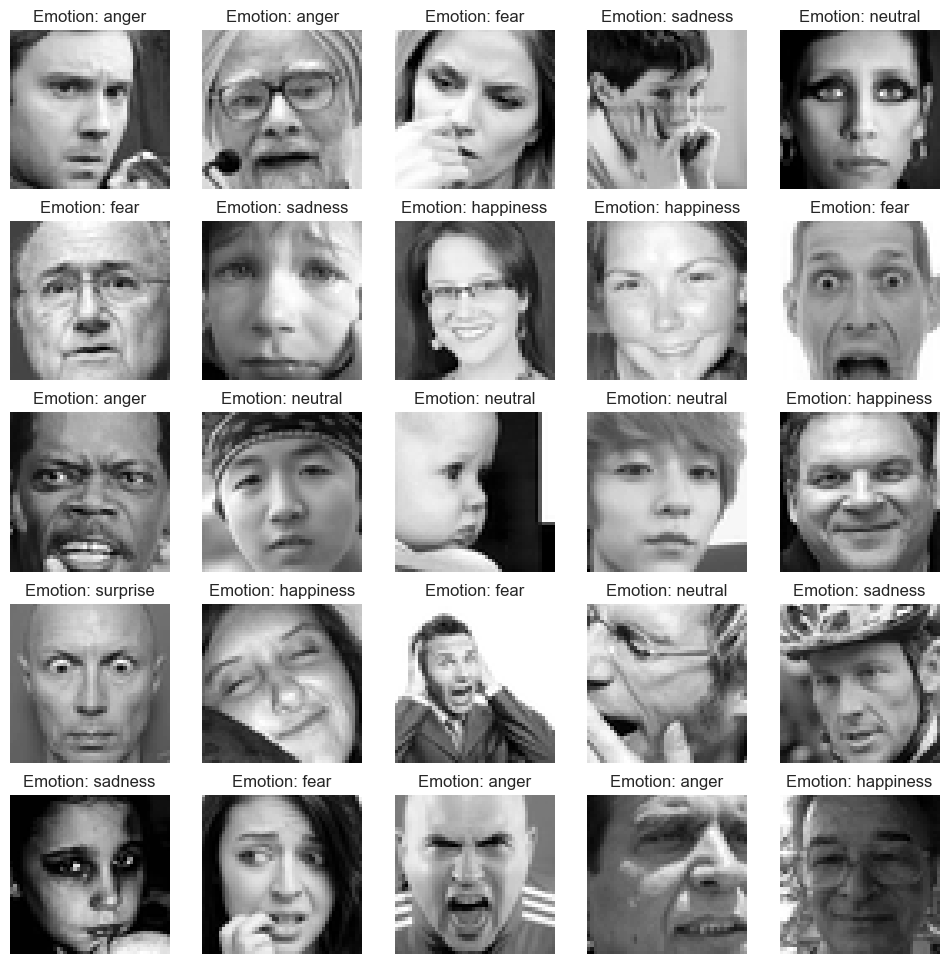

In [14]:
utils.show_images(df, emotions_dict, num_images=25, num_cols=5)

## Split the data into train, validation and test

In [15]:
# Split the dataset based on the "Usage" column
train_df = df[df['Usage'] == 'Training']
public_test_df = df[df['Usage'] == 'PublicTest']
private_test_df = df[df['Usage'] == 'PrivateTest']

In [16]:
# Print the lengths of the sets
print(f"Training set length: {len(train_df)}")
print(f"Public Test set set length: {len(public_test_df)}")
print(f"Private Test set length: {len(private_test_df)}")   

Training set length: 28709
Public Test set set length: 3589
Private Test set length: 3589


## Plot label occurence for all individual sets

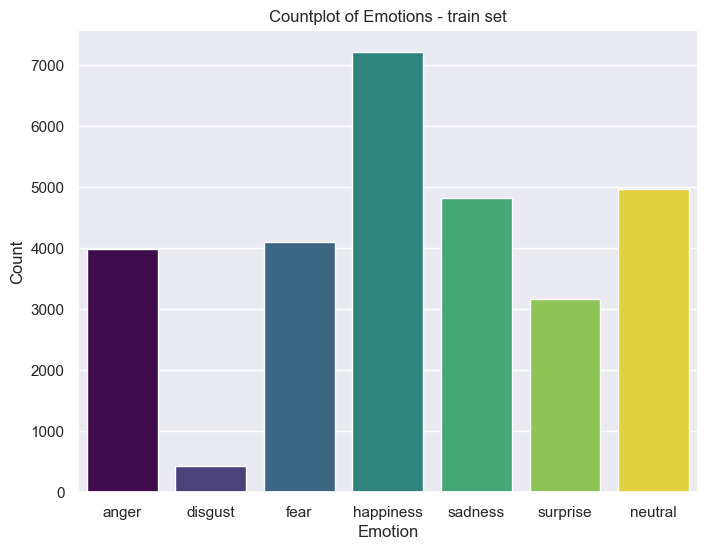

In [17]:
utils.plot_emotion_count(train_df, emotions_dict, "train set")

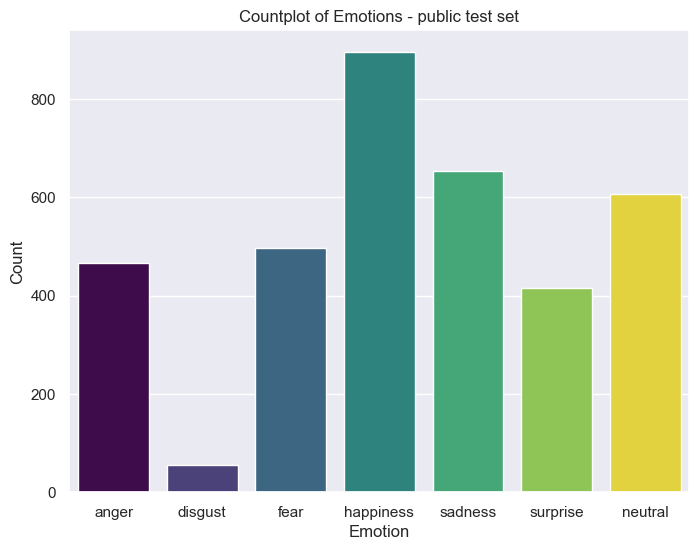

In [18]:
utils.plot_emotion_count(public_test_df, emotions_dict, "public test set")

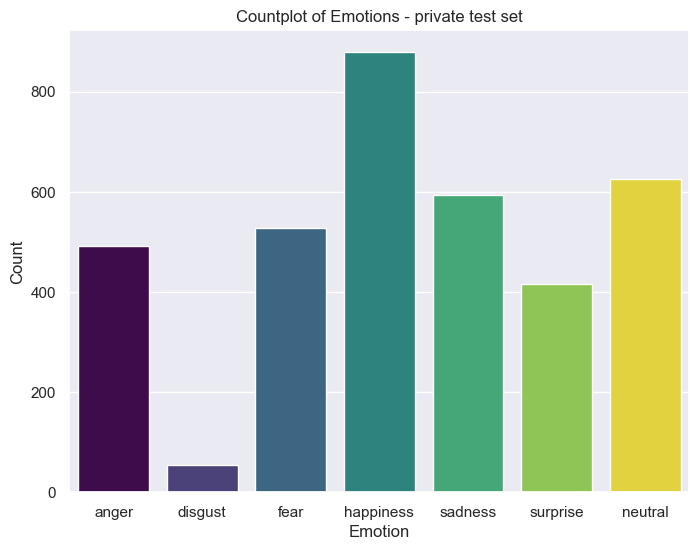

In [19]:
utils.plot_emotion_count(private_test_df, emotions_dict, "private test set")

## Split the sets into data and labels

In [20]:
train_labels, train_data = utils.split_labels_and_data(train_df)
public_test_labels, public_test_data = utils.split_labels_and_data(public_test_df)
private_test_labels, private_test_data = utils.split_labels_and_data(private_test_df)

In [21]:
# some more preprocessing of the data
train_data = utils.convert_string_to_int_array(train_data)
public_test_data = utils.convert_string_to_int_array(public_test_data)
private_test_data = utils.convert_string_to_int_array(private_test_data)

In [22]:
train_labels = train_labels.values
public_test_labels = public_test_labels.values
private_test_labels = private_test_labels.values

In [23]:
print(len(train_data))

28709


## Create a custom dataset class

In [24]:
from torch.utils.data import Dataset, DataLoader, random_split
import math

In [25]:
train_dataset = utils.CustomDataset(train_data, train_labels)
public_test_set = utils.CustomDataset(public_test_data, public_test_labels)
private_test_set = utils.CustomDataset(private_test_data, private_test_labels)

# split further into train and validation set
validation_set_fraction = 0.15
train_set_length = math.floor(len(train_dataset) * (1-validation_set_fraction))
validation_set_length = math.ceil(len(train_dataset) * (validation_set_fraction))

# train validation split
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_set_length, validation_set_length])

# Simple CNN for first tests

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(9216, 512)  
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [27]:
# set up cude if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Set up Dataloaders

In [28]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 1

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set) * train_set_sample_fraction)
# number of samples
n_samples = int(len(train_set)*train_set_sample_fraction)

# Use a RandomSampler with random indices
random_sampler = RandomSampler(data_source=train_set, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 512

train_dataloader = DataLoader(train_set, batch_size, sampler=random_sampler)
valid_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
public_test_dataloader = DataLoader(public_test_set, batch_size=batch_size, shuffle=False)
private_test_dataloader = DataLoader(private_test_set, batch_size=batch_size, shuffle=False)

In [29]:
# load tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs

## Training

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.tensorboard import SummaryWriter

# set up some hyperparams and saving paths
learning_rate = 0.001
save_path = 'models/best_simple_model.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_simple_CNN", comment='SimpleCNN')

# Initialize model, loss function, optimizer
model = SimpleCNN()
model.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 1, 48, 48).to(device)
writer.add_graph(model, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15
# Start the training loop

#utils.train(train_dataloader, valid_dataloader, model, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

## Test model (classification report, confusion matrix and misclassified images)

In [31]:
# Create an instance of the model
model = SimpleCNN()

# Load the saved model state dictionary
model.load_state_dict(torch.load('models/best_simple_model.pth'))

<All keys matched successfully>

In [32]:
model

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=7, bias=True)
)

## Test on Public Test set

In [33]:
#utils.test(model, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

## Test on Private Test set

In [34]:
#utils.test(model, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

## Resample the training data

In [35]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 1

# get the train_sample_weights
train_sample_weights = utils.get_datapoint_weights(train_set)

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set) * train_set_sample_fraction)
# number of samples
n_samples = int(len(train_set)*train_set_sample_fraction)

# Use a WeightedRandomSampler with random indices
weighted_random_sampler = WeightedRandomSampler(weights=train_sample_weights, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 512

upsampled_train_dataloader = DataLoader(train_set, batch_size, sampler=weighted_random_sampler)

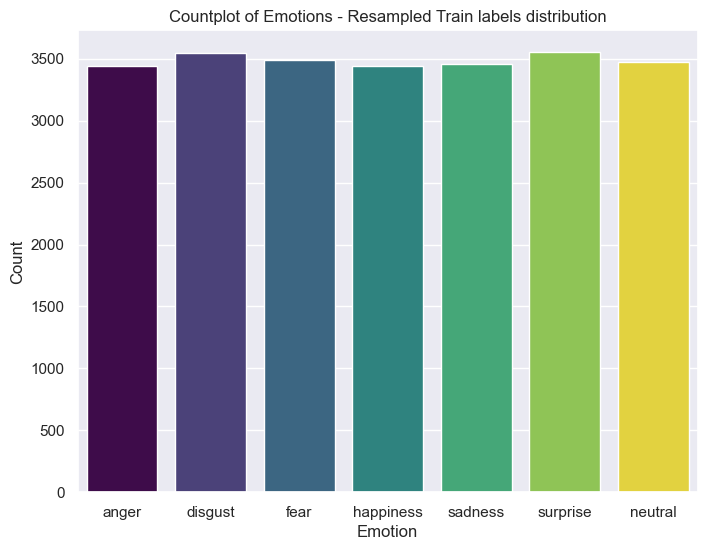

In [36]:
utils.plot_emotion_count(upsampled_train_dataloader, emotions_dict, "Resampled Train labels distribution")

## Training

In [37]:
# set up some hyperparams and saving paths
learning_rate = 0.001
save_path = 'models/best_simple_model_resampled.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_simple_CNN_resampled", comment='SimpleCNN_resampled')

# Initialize model, loss function, optimizer
model = SimpleCNN()
model.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 1, 48, 48).to(device)
writer.add_graph(model, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15
# Start the training loop

#utils.train(upsampled_train_dataloader, valid_dataloader, model, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

## Test model (classification report, confusion matrix and misclassified images)

In [38]:
# Create an instance of the model
model = SimpleCNN()

# Load the saved model state dictionary
model.load_state_dict(torch.load('models/best_simple_model_resampled.pth'))

<All keys matched successfully>

## Test on Public Testset

In [39]:
#utils.test(model, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

## Test on Private Test set

In [40]:
#utils.test(model, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

Resampling did not lead to better accuracy!

## Data augmentation

In [41]:
from torchvision import transforms
from PIL import Image
from torch.utils.data import Subset

# Define the transformations 
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(size=(48, 48), scale=(0.8, 1.2), ratio=(0.9, 1.1)),
    transforms.RandomAffine(degrees=10, scale=(0.9, 1.1), shear=5),
    transforms.ToTensor()
])

# Create augmented subsets with transformations
train_set_augmented = utils.CustomDataset(train_data, train_labels, train_transform)

In [42]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 1

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set_augmented) * train_set_sample_fraction)

# number of samples
n_samples = int(len(train_set_augmented)*train_set_sample_fraction)

# Use a RandomSampler with random indices
random_sampler = RandomSampler(data_source=train_set_augmented, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 512

train_dataloader_augmented = DataLoader(train_set_augmented, batch_size, sampler=random_sampler)

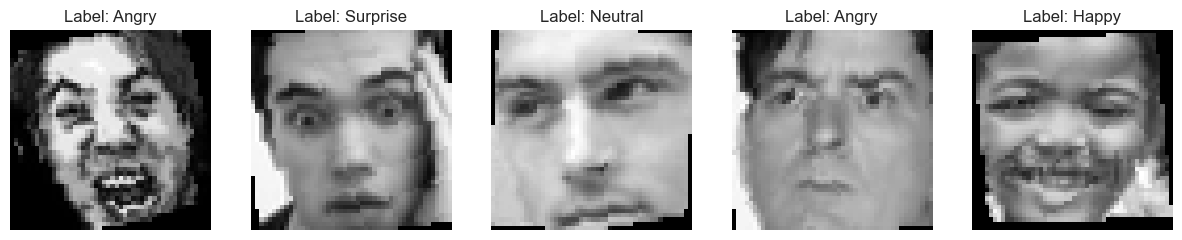

In [43]:
def plot_batch_images(images, labels, k=5):
    """
    Plot the first "k" original and augmented images from a batch.

    Parameters:
    - images (torch.Tensor): The batch of images.
    - labels (torch.Tensor): The corresponding labels.
    - k (int): Number of pairs of images to plot.

    Returns:
    None
    """

    label_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    
    fig, axes = plt.subplots(1, k, figsize=(15, 6))

    for i in range(k):
        # Get the i-th original image from the batch
        image = images[i].squeeze().numpy()

        # Plot original image
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label_dict[labels[i].item()]}")
        axes[i].axis('off')
    plt.show()

# Example usage
for batch in train_dataloader_augmented:
    images, labels = batch
    plot_batch_images(images, labels, k=5)
    break

In [44]:
# set up some hyperparams and saving paths
learning_rate = 0.001
save_path = 'models/best_simple_model_augmented.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_simple_CNN_augmented", comment='SimpleCNN_augmented')

# Initialize model, loss function, optimizer
model = SimpleCNN()
model.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 1, 48, 48).to(device)
writer.add_graph(model, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15

# Start the training loop
#utils.train(train_dataloader_augmented, valid_dataloader, model, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

In [45]:
## Test model (classification report, confusion matrix and misclassified images)

In [46]:
# Create an instance of the model
model = SimpleCNN()

# Load the saved model state dictionary
model.load_state_dict(torch.load('models/best_simple_model_augmented.pth'))

<All keys matched successfully>

In [47]:
# Public Test set

In [48]:
#utils.test(model, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

In [49]:
## Private Test set

In [50]:
#utils.test(model, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

# Augmentation with upsampling

In [51]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 1

# get the train_sample_weights
train_sample_weights = utils.get_datapoint_weights(train_set)

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set) * train_set_sample_fraction)
# number of samples
n_samples = int(len(train_set)*train_set_sample_fraction)

# Use a WeightedRandomSampler with random indices
weighted_random_sampler = WeightedRandomSampler(weights=train_sample_weights, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 512

upsampled_train_dataloader_augmented = DataLoader(train_set_augmented, batch_size, sampler=weighted_random_sampler)

In [52]:
# set up some hyperparams and saving paths
learning_rate = 0.001
save_path = 'models/best_simple_model_augmented_upsampled.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_simple_CNN_augmented_upsampled", comment='SimpleCNN_augmented_upsampled')

# Initialize model, loss function, optimizer
model = SimpleCNN()
model.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 1, 48, 48).to(device)
writer.add_graph(model, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15

# Start the training loop
#utils.train(upsampled_train_dataloader_augmented, valid_dataloader, model, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

In [53]:
# Create an instance of the model
model = SimpleCNN()

# Load the saved model state dictionary
model.load_state_dict(torch.load('models/best_simple_model_augmented_upsampled.pth'))

<All keys matched successfully>

In [54]:
#utils.test(model, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

In [55]:
#utils.test(model, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

In [56]:
# load tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1590528), started 0:00:10 ago. (Use '!kill 1590528' to kill it.)

# Use Advanced Model (ConvNeXt Tiny)
https://pytorch.org/vision/main/models/generated/torchvision.models.convnext_tiny.html#torchvision.models.convnext_tiny

In [57]:
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

def create_custom_convext_net(freeze_pretrained=False):
    # Load pretrained ConvNeXt model
    convnext_tiny = torchvision.models.convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)

    # Freeze all pretrained layers
    if freeze_pretrained:
        for param in convnext_tiny.parameters():
            param.requires_grad = False

    # Modify the final fully connected layer for the specified number of classes
    in_features = 768  # Number of features of the classifier
    out_features = 7  # Number of output classes
    convnext_tiny.classifier[-1] = nn.Linear(in_features, out_features, bias=True)

    # Create a list of parameters to be optimized
    parameters_to_optimize = filter(lambda p: p.requires_grad, convnext_tiny.parameters())

    return convnext_tiny, parameters_to_optimize

In [58]:
convnext_tiny_baseline, _ = create_custom_convext_net()

In [59]:
# Print the modified model architecture
print(convnext_tiny_baseline)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [60]:
# Define the transformations for ConvNeXt model
resize_size = [230]
crop_size = [224]
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(resize_size, interpolation=Image.BILINEAR),
    transforms.CenterCrop(crop_size),
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=normalize_mean, std=normalize_std)
])

train_dataset = utils.CustomDataset(train_data, train_labels, transform=transform)
public_test_set = utils.CustomDataset(public_test_data, public_test_labels, transform=transform)
private_test_set = utils.CustomDataset(private_test_data, private_test_labels, transform=transform)

# split further into train and validation set
validation_set_fraction = 0.15
train_set_length = math.floor(len(train_dataset) * (1-validation_set_fraction))
validation_set_length = math.ceil(len(train_dataset) * (validation_set_fraction))

# train validation split
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_set_length, validation_set_length])

## Set Up Dataloaders again for baseline training

In [61]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 0.025

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set) * train_set_sample_fraction)
# number of samples
n_samples = int(len(train_set)*train_set_sample_fraction)

# Use a RandomSampler
random_sampler = RandomSampler(data_source=train_set, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 16

train_dataloader = DataLoader(train_set, batch_size, sampler=random_sampler)
valid_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
public_test_dataloader = DataLoader(public_test_set, batch_size=batch_size, shuffle=False)
private_test_dataloader = DataLoader(private_test_set, batch_size=batch_size, shuffle=False)

In [62]:
# Example usage
#for batch in train_dataloader:
    #images, labels = batch
  #  images = images[:,0,:,:]
    #print(images)
    #plot_batch_images(images, labels, k=5)
    #break

In [63]:
# load tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1590528), started 0:00:10 ago. (Use '!kill 1590528' to kill it.)

In [64]:
# set up some hyperparams and saving paths
learning_rate = 0.0001
save_path = 'models/CovNext_baseline.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_CovNext_baseline", comment='CovNext_baseline')

# Initialize model, loss function, optimizer
convnext_tiny_baseline.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 3, 224, 224).to(device)
writer.add_graph(convnext_tiny_baseline, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnext_tiny_baseline.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15

# Start the training loop
#utils.train(train_dataloader, valid_dataloader, convnext_tiny_baseline, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

## Test model (classification report, confusion matrix and misclassified images)

In [65]:
# Create an instance of the model

# Load the saved model state dictionary
convnext_tiny_baseline.load_state_dict(torch.load('models/CovNext_baseline.pth'))#

<All keys matched successfully>

## Test on Public Test Set

In [66]:
#utils.test(convnext_tiny_baseline, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

## Test on Private Test Set

In [67]:
#utils.test(convnext_tiny_baseline, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

# freeze pretrained layers and finetune later

In [68]:
convnext_tiny_pretrained, parameters_to_optimize = create_custom_convext_net(freeze_pretrained=True)

In [69]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 0.05

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set) * train_set_sample_fraction)
# number of samples
n_samples = int(len(train_set)*train_set_sample_fraction)

# Use a RandomSampler
random_sampler = RandomSampler(data_source=train_set, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 16

train_dataloader = DataLoader(train_set, batch_size, sampler=random_sampler)

In [70]:
# set up some hyperparams and saving paths
learning_rate = 0.0001
save_path = 'models/CovNext_frozen.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_CovNext_frozen", comment='CovNext_frozen')

# Initialize model, loss function, optimizer
convnext_tiny_pretrained.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 3, 224, 224).to(device)
writer.add_graph(convnext_tiny_pretrained, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters_to_optimize, lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15

# Start the training loop
#utils.train(train_dataloader, valid_dataloader, convnext_tiny_pretrained, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

In [71]:
convnext_tiny_pretrained.load_state_dict(torch.load('models/CovNext_frozen.pth'))

<All keys matched successfully>

In [72]:
#utils.test(convnext_tiny_pretrained, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

In [73]:
#utils.test(convnext_tiny_pretrained, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

# finetune the frozen model with lower learning rate

In [74]:
for param in convnext_tiny_pretrained.parameters():
    param.requires_grad = True

In [75]:
# set up some hyperparams and saving paths
learning_rate = 0.0001
save_path = 'models/CovNext_frozen_finetuned.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_CovNext_frozen_finetuned", comment='CovNext_frozen_finetuned')

# Initialize model, loss function, optimizer
convnext_tiny_pretrained.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 3, 224, 224).to(device)
writer.add_graph(convnext_tiny_pretrained, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnext_tiny_pretrained.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15

# Start the training loop
#utils.train(train_dataloader, valid_dataloader, convnext_tiny_pretrained, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

In [76]:
convnext_tiny_pretrained.load_state_dict(torch.load('models/CovNext_frozen_finetuned.pth'))

<All keys matched successfully>

In [77]:
#utils.test(convnext_tiny_pretrained, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

In [78]:
#utils.test(convnext_tiny_pretrained, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

# Augmentation

In [79]:
# Define the transformations for ConvNeXt model
resize_size = [230]
crop_size = [224]
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]


train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(size=(48, 48), scale=(0.8, 1.2), ratio=(0.9, 1.1)),
    transforms.RandomAffine(degrees=10, scale=(0.9, 1.1), shear=5),
    transforms.Resize(resize_size, interpolation=Image.BILINEAR),
    transforms.CenterCrop(crop_size),
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=normalize_mean, std=normalize_std)
])



train_dataset = utils.CustomDataset(train_data, train_labels, transform=train_transform)

# split further into train and validation set
validation_set_fraction = 0.15
train_set_length = math.floor(len(train_dataset) * (1-validation_set_fraction))
validation_set_length = math.ceil(len(train_dataset) * (validation_set_fraction))

# train validation split
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_set_length, validation_set_length])

In [80]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 0.025

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set) * train_set_sample_fraction)
# number of samples
n_samples = int(len(train_set)*train_set_sample_fraction)

# Use a RandomSampler
random_sampler = RandomSampler(data_source=train_set, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 16

train_dataloader = DataLoader(train_set, batch_size, sampler=random_sampler)

In [81]:
# load tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1590528), started 0:00:14 ago. (Use '!kill 1590528' to kill it.)

In [82]:
convnext_tiny_frozen_augmented, parameters_to_optimize = create_custom_convext_net(freeze_pretrained=True)

In [83]:
# set up some hyperparams and saving paths
learning_rate = 0.0001
save_path = 'models/CovNext_frozen_augmented.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_CovNext_frozen_augmented.pth", comment='CovNext_frozen_augmented.pth')

# Initialize model, loss function, optimizer
convnext_tiny_frozen_augmented.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 3, 224, 224).to(device)

writer.add_graph(convnext_tiny_frozen_augmented, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters_to_optimize, lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15

# Start the training loop
#utils.train(train_dataloader, valid_dataloader, convnext_tiny_frozen_augmented, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

# Train on full model with more data

In [84]:
# load tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1590528), started 0:00:16 ago. (Use '!kill 1590528' to kill it.)

In [85]:
convnext_tiny_frozen_augmented.load_state_dict(torch.load('models/CovNext_frozen_augmented.pth'))

<All keys matched successfully>

In [86]:
#utils.test(convnext_tiny_frozen_augmented, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

In [87]:
for param in convnext_tiny_frozen_augmented.parameters():
    param.requires_grad = True

In [88]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 0.5

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set) * train_set_sample_fraction)
# number of samples
n_samples = int(len(train_set)*train_set_sample_fraction)

# Use a RandomSampler
random_sampler = RandomSampler(data_source=train_set, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 32

train_dataloader = DataLoader(train_set, batch_size, sampler=random_sampler)

In [89]:
# set up some hyperparams and saving paths
learning_rate = 0.00001
save_path = 'models/CovNext_finetuned_augmented.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_CovNext_finetuned_augmented.pth", comment='CovNext_finetuned_augmented.pth')

# Initialize model, loss function, optimizer
convnext_tiny_frozen_augmented.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 3, 224, 224).to(device)

writer.add_graph(convnext_tiny_frozen_augmented, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnext_tiny_frozen_augmented.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15

# Start the training loop
#utils.train(train_dataloader, valid_dataloader, convnext_tiny_frozen_augmented, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

In [90]:
convnext_tiny_frozen_augmented.load_state_dict(torch.load('models/CovNext_finetuned_augmented.pth'))

<All keys matched successfully>

In [91]:
#utils.test(convnext_tiny_frozen_augmented, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

In [92]:
#utils.test(convnext_tiny_frozen_augmented, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

# Finetune the previously best model on the augmented data

In [93]:
convnext_tiny_best, parameters_to_optimize = create_custom_convext_net(freeze_pretrained=False)

In [94]:
convnext_tiny_best.load_state_dict(torch.load('models/CovNext_frozen_finetuned.pth'))

<All keys matched successfully>

In [95]:
# set up some hyperparams and saving paths
learning_rate = 0.0001
save_path = 'models/CovNext_best.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_CovNext_best", comment='CovNext_best')

# Initialize model, loss function, optimizer
convnext_tiny_best.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 3, 224, 224).to(device)

writer.add_graph(convnext_tiny_best, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnext_tiny_best.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15

# Start the training loop
#utils.train(train_dataloader, valid_dataloader, convnext_tiny_best, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

In [96]:
convnext_tiny_best.load_state_dict(torch.load('models/CovNext_best.pth'))

<All keys matched successfully>

In [97]:
#utils.test(convnext_tiny_best, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

In [98]:
#utils.test(convnext_tiny_best, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

# finetune further on more data and less learning rate

In [106]:
convnext_tiny_best.load_state_dict(torch.load('models/CovNext_best_finetuned.pth'))

<All keys matched successfully>

In [107]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 0.5

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set) * train_set_sample_fraction)
# number of samples
n_samples = int(len(train_set)*train_set_sample_fraction)

# Use a RandomSampler
random_sampler = RandomSampler(data_source=train_set, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 32

train_dataloader = DataLoader(train_set, batch_size, sampler=random_sampler)

In [108]:
# set up some hyperparams and saving paths
learning_rate = 0.000005
save_path = 'models/CovNext_best_finetuned2.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_CovNext_best_finetuned2.pth", comment='CovNext_best_finetuned2.pth')

# Initialize model, loss function, optimizer
convnext_tiny_best.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 3, 224, 224).to(device)

writer.add_graph(convnext_tiny_best, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnext_tiny_best.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15

In [109]:
utils.train(train_dataloader, valid_dataloader, convnext_tiny_best, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

Initial Stats: 



Evaluation:   0%|          | 0/382 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Train Loss: 0.0264, Train Accuracy: 0.9814
Validation Loss: 0.2434, Validation Accuracy: 0.9487
--------------------------------------------------

Starting training: 



Training:   0%|          | 0/382 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Training:   0%|          | 0/382 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Training:   0%|          | 0/382 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Training:   0%|          | 0/382 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Training:   0%|          | 0/382 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Epoch 5/250 ==> Train Loss: 0.0408, Train Accuracy: 0.9709 Validation Loss: 0.2447, Validation Accuracy: 0.9461


Training:   0%|          | 0/382 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Training:   0%|          | 0/382 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Training:   0%|          | 0/382 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Training:   0%|          | 0/382 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Training:   0%|          | 0/382 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Epoch 10/250 ==> Train Loss: 0.0380, Train Accuracy: 0.9733 Validation Loss: 0.2487, Validation Accuracy: 0.9475


Training:   0%|          | 0/382 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Training:   0%|          | 0/382 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Training:   0%|          | 0/382 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Training:   0%|          | 0/382 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Training:   0%|          | 0/382 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Epoch 15/250 ==> Train Loss: 0.0380, Train Accuracy: 0.9741 Validation Loss: 0.2457, Validation Accuracy: 0.9482


Training:   0%|          | 0/382 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Training:   0%|          | 0/382 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

No improvement for 15 consecutive epochs. Stopping training.


In [103]:
convnext_tiny_best.load_state_dict(torch.load('models/CovNext_best_finetuned.pth'))

<All keys matched successfully>

Testing:   0%|          | 0/225 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger     0.6188    0.6188    0.6188       467
     disgust     0.8049    0.5893    0.6804        56
        fear     0.5957    0.5081    0.5484       496
   happiness     0.8709    0.8816    0.8762       895
     sadness     0.5602    0.6126    0.5852       653
    surprise     0.8163    0.8458    0.8308       415
     neutral     0.6266    0.6277    0.6272       607

    accuracy                         0.6952      3589
   macro avg     0.6991    0.6691    0.6810      3589
weighted avg     0.6949    0.6952    0.6940      3589





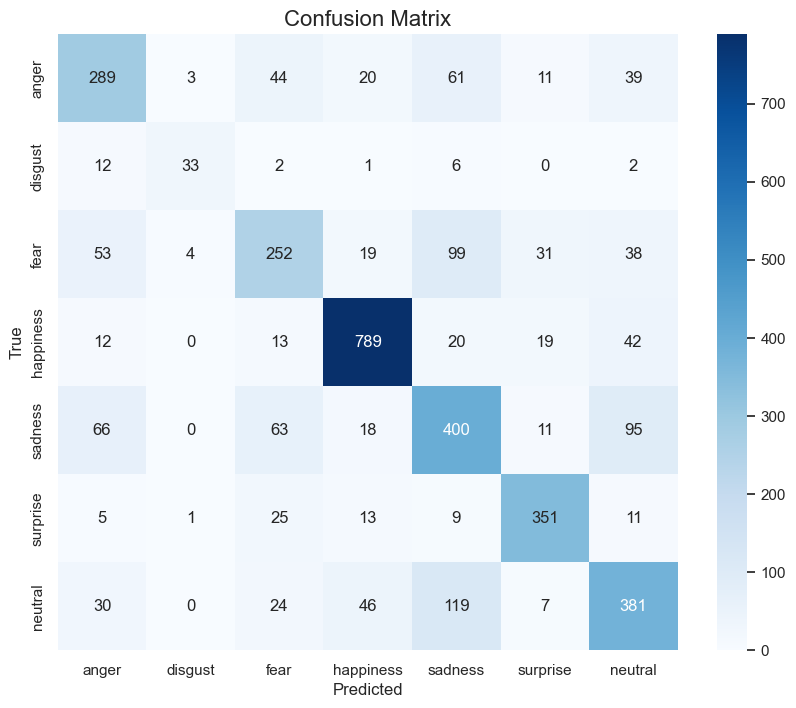



Misclassified Images: 



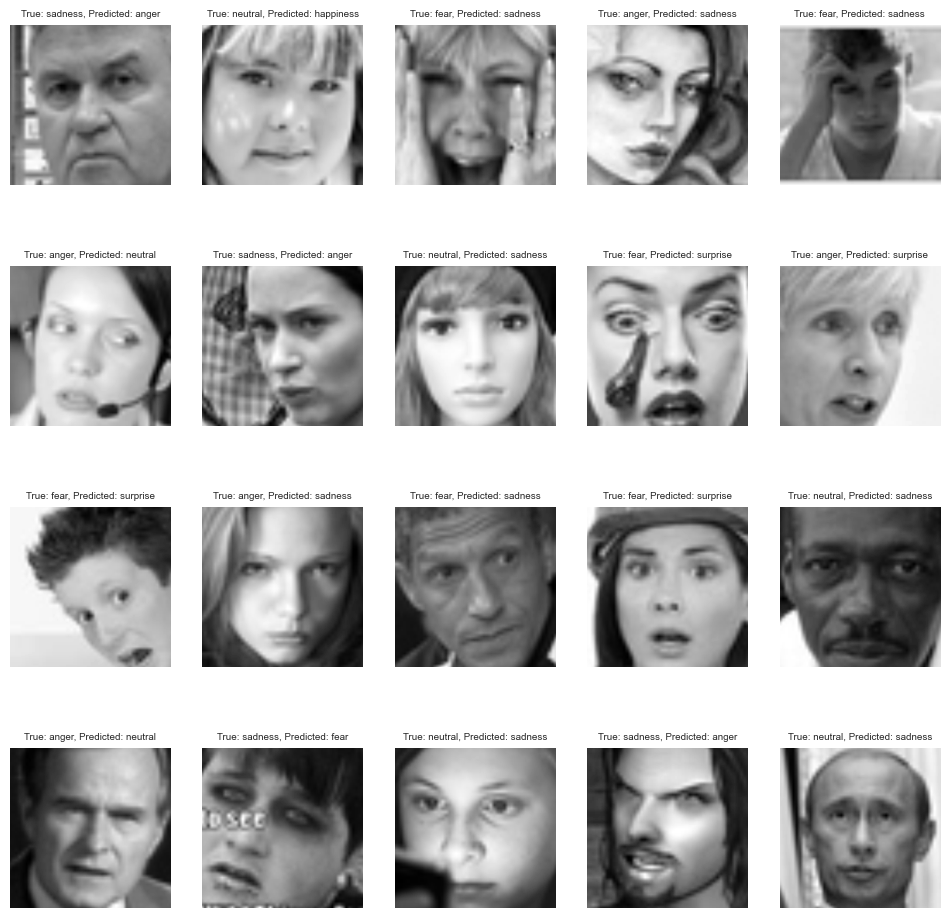

In [104]:
utils.test(convnext_tiny_best, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

Testing:   0%|          | 0/225 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger     0.6468    0.6191    0.6327       491
     disgust     0.8367    0.7455    0.7885        55
        fear     0.6061    0.5246    0.5624       528
   happiness     0.9048    0.8976    0.9012       879
     sadness     0.5413    0.5960    0.5673       594
    surprise     0.8066    0.8221    0.8143       416
     neutral     0.6652    0.7045    0.6843       626

    accuracy                         0.7099      3589
   macro avg     0.7154    0.7013    0.7072      3589
weighted avg     0.7112    0.7099    0.7097      3589





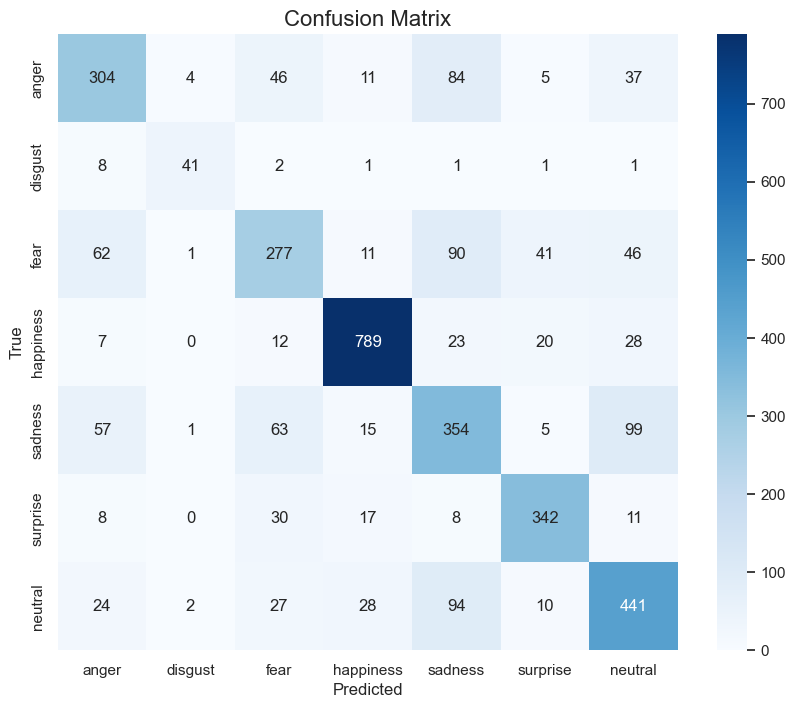



Misclassified Images: 



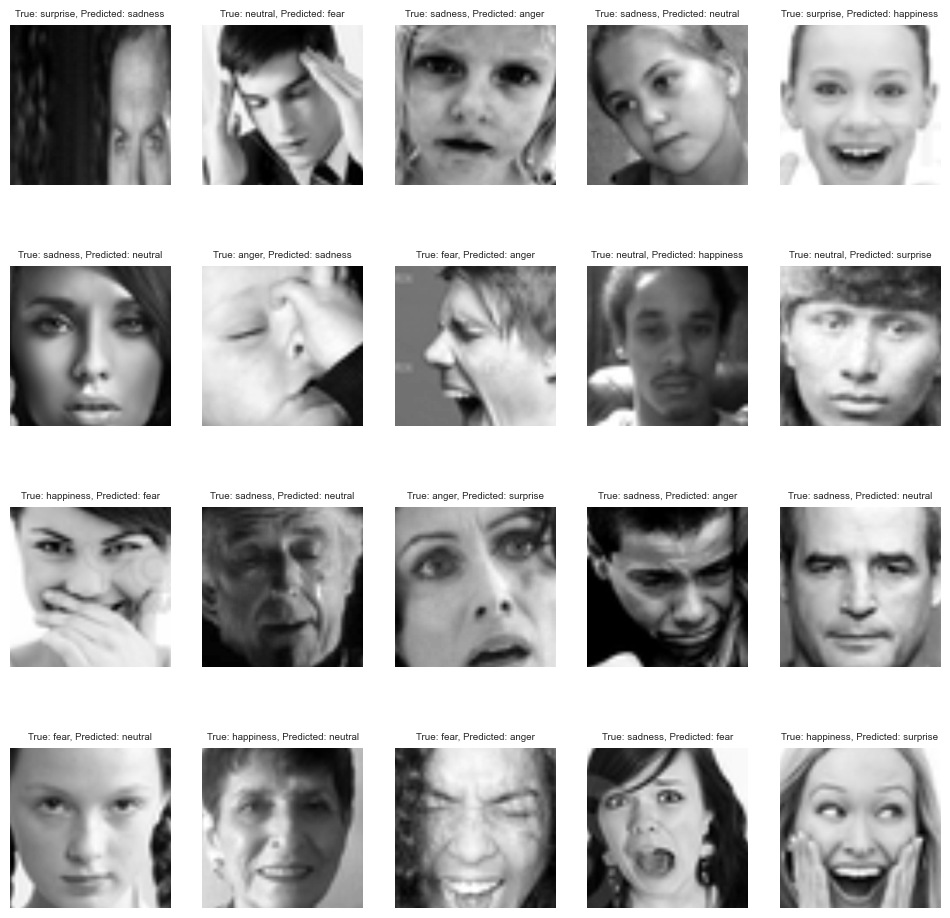

In [105]:
utils.test(convnext_tiny_best, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)